In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from src.aff_core import *

import matplotlib as mpl

mpl.rcParams.update({'pgf.preamble': r'\usepackage{amsmath}'})
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'stix:italic'

In [18]:
def xavier_uniform_scaled(tensor, scale=1.0, bias=[0,0]):

    fan_in, fan_out = nn.init._calculate_fan_in_and_fan_out(tensor)
    std = np.sqrt(2.0 / float(fan_in + fan_out))
    a = np.sqrt(3.0) * std  # Calculate uniform bounds from standard deviation

    up_bound = scale*(a+bias[1])
    low_bound = scale*(-a+bias[0])

    #print(low_bound, up_bound)

    with torch.no_grad():
        return tensor.uniform_(low_bound, up_bound)

class MLP(nn.Module):
    def __init__(self, hidden_dim=100, output_dim=2, activation_fn=F.relu, nb_hidden=3, scale=1., translate = [0., 0.]):

        super(MLP, self).__init__()
        
        layers = [nn.Linear(2, hidden_dim)]
        
        for _ in range(nb_hidden - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim)]

        layers += [nn.Linear(hidden_dim, output_dim)]

        self.layers = nn.Sequential(*layers)
        self.activation = activation_fn

        # Initialize weights using Glorot (Xavier) initialization

        for layer in layers:
            xavier_uniform_scaled(layer.weight, scale=scale, bias=translate)
            nn.init.uniform_(layer.bias, -1, 1)
        

    def forward(self, x):
        aff_scores = []

        for layer in self.layers[:-1]:
            x = layer(x) 
            aff_scores.append(round(rho_aff(x.T, self.activation(x).T),2))  
            x = self.activation(x)

        x = self.layers[-1](x)
        
        return x, round(np.mean(aff_scores),2), aff_scores

def generate_uniform_grid(size):
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    xv, yv = np.meshgrid(x, y)
    grid = np.stack([xv.flatten(), yv.flatten()], axis=1)

    return torch.tensor(grid, dtype=torch.float32)

In [22]:
np.random.seed(12)

grid_size = 32  # Example grid size
input_grid = generate_uniform_grid(grid_size)

assert len(input_grid) == grid_size**2

# Define input and output dimensions
output_dim = 1
hidden_dim = 40 # if you change the hidden_dim, translate parameter below needs to be adjusted

translate = [-0.05, -0.05] # this works well for showing that ReLU can be sensitive to weights' magnitude change

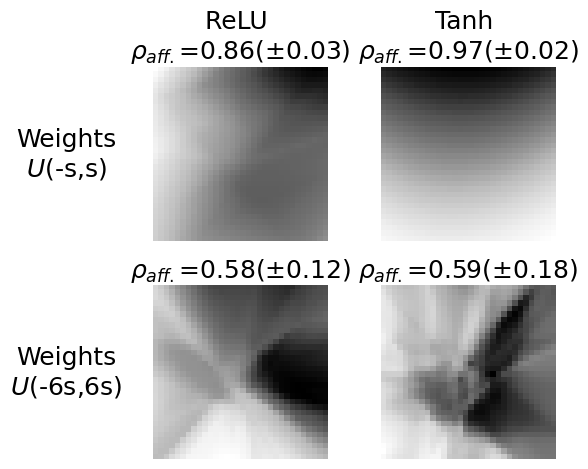

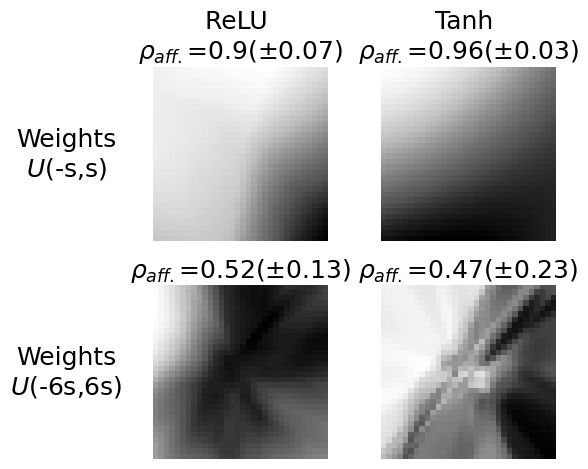

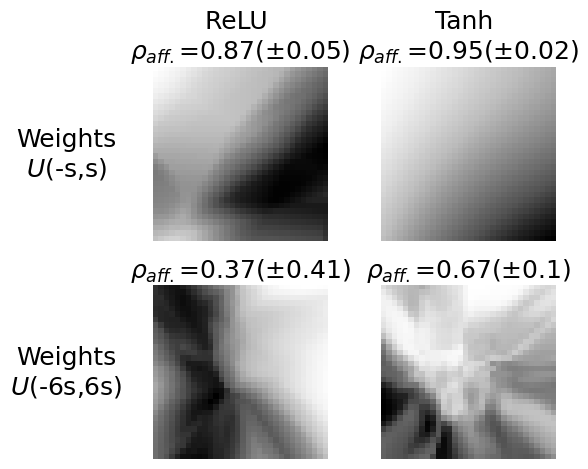

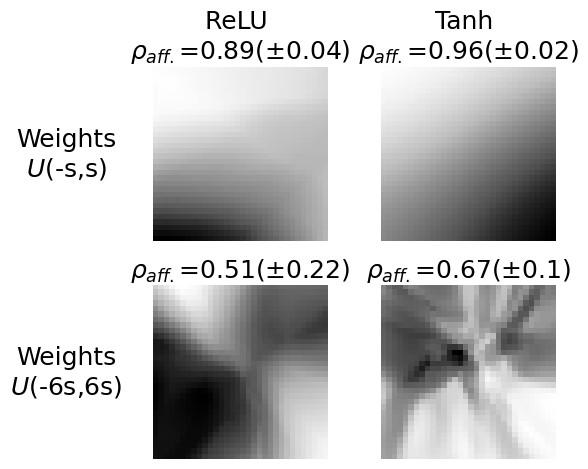

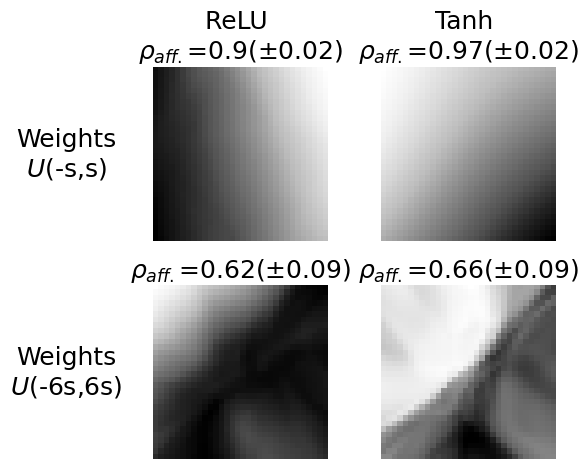

In [24]:
# Instantiate the model
seeds = np.random.randint(0, 1e6, 5) # generate several outputs for different random seeds 

for seed in seeds:

    f, axis = plt.subplots(nrows=2, ncols=2, frameon=False)

    for ax in axis.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_axis_off()

    torch.manual_seed(seed)

    # Forward pass with the input grid
    model = MLP(hidden_dim, output_dim, F.relu, translate=translate)
    
    with torch.no_grad():
        output, aff_scores, all_scores = model(input_grid)
        std = np.std(all_scores)

        output = (output-torch.min(output))/(torch.max(output)-torch.min(output))
        output = output.detach().numpy().reshape((grid_size,grid_size))
        axis[0,0].imshow(output, cmap='Greys')
        axis[0,0].set_title('ReLU \n' + r'$\rho_{aff.}$='+str(aff_scores)+r'$ (\pm$'+str(round(std,2))+')', fontsize=18)

        axis[0,0].text(-.5, 0.5, "Weights\n"r"$\mathcal{U}$""(-s,s)", transform=axis[0,0].transAxes, 
            verticalalignment='center', horizontalalignment='center', fontsize=18)

        model.activation = F.tanh

        output, aff_scores, all_scores = model(input_grid)
        std = np.std(all_scores)

        output = (output-torch.min(output))/(torch.max(output)-torch.min(output))
        output = output.detach().numpy().reshape((grid_size,grid_size))

        axis[0,1].imshow(output, cmap='Greys')
        axis[0,1].set_title('Tanh \n' + r'$\rho_{aff.}$='+str(aff_scores)+r'$ (\pm$'+str(round(std,2))+')', fontsize=18)

        model = MLP(hidden_dim, output_dim, F.relu, scale=6., translate=translate)

        output, aff_scores, all_scores = model(input_grid)
        std = np.std(all_scores)

        output = (output-torch.min(output))/(torch.max(output)-torch.min(output))
        output = output.detach().numpy().reshape((grid_size,grid_size))
        axis[1,0].imshow(output, cmap='Greys')
        axis[1,0].set_title(r'$\rho_{aff.}$=' + str(aff_scores)+r'$ (\pm$'+str(round(std,2))+')', fontsize=18)

        axis[1,0].text(-.5, 0.5, "Weights\n"r"$\mathcal{U}$""(-6s,6s)", transform=axis[1,0].transAxes, 
            verticalalignment='center', horizontalalignment='center', fontsize=18)

        model.activation = F.tanh

        output, aff_scores, all_scores = model(input_grid)
        std = np.std(all_scores)

        output = (output-torch.min(output))/(torch.max(output)-torch.min(output))
        output = output.detach().numpy().reshape((grid_size,grid_size))

        axis[1,1].imshow(output, cmap='Greys')
        axis[1,1].set_title(r'$\rho_{aff.}$=' + str(aff_scores)+r'$ (\pm$'+str(round(std,2))+')', fontsize=18)
        
        plt.tight_layout()
        if np.sum(translate) != 0:
            flag = 'shifted'
        else:
            flag = 'raw'
            
    #plt.savefig('relu_tanh_'+str(flag)+'_'+str(seed)+'.pdf', dpi=300, bbox_inches='tight')